### Methodology
This notebook is created to verify Runze's code in generating data. The procedures are:
1. Paste Runze's code from Github
2. Run Runze's code on one sample
3. Draw the heat map of the flow using formula $dist = \sqrt{fx^2+fy^2+fz^2}$
4. Read one data from Runze's training set
5. Draw the heat map of its flow using formula $dist = \sqrt{fx^2+fy^2+fz^2}$
6. Compare and discuss

### Step 1-2:Runze's code, pasted from Gitlab
Modifications: 
1. folder: cannot access blackhole using folder = r"\\istar-blackhole\data2\RadOnc_Brain", so use the mnt path instead
2. index = 0, avoid unequal input of image size, as the original images in Radonc is not fixed in size

In [49]:
import os

import torch
from layers import SpatialTransformer
import numpy as np
import nibabel as nib

from skimage.transform import resize
from scipy.ndimage.interpolation import affine_transform

from deformation_simulator import Simulator, SourceGen
from helpers import normalizeImage, random_transform

folder = '/mnt/blackhole-data2/RadOnc_Brain'
write_dir = "./"

CT_min = -100.0
CT_max = 100.0
CBCT_min = -100.0
CBCT_max = 100.0
T1_min = -100.0
T1_max = 2300.0
config = dict()

config['image_size'] = [128, 160, 128]
config['num_samples'] = 1
config['augment_translation'] = 5
config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] = [5e-3, 3e-2]  # [1e-2,1e-1] # decay power range in deformation simulation
config['augment_deformation_range'] = [2, 5]  # deformation magnitude range in deformation simulation

# load synthesis generator

indices = np.arange(6, 8)
n_moving = []
n_fixed = []
n_cbct = []
n_mask_ventricle = []
n_mask_brain = []
for i in indices:
    n_fixed.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CT-crop-resampled.nii")).get_fdata())
    n_cbct.append(nib.load(os.path.join(folder,f"NormalAnatomy",f"atlas_brain_{i:02}_CBCT_OArm-crop-resampled.nii")).get_fdata())
    n_moving.append(nib.load(os.path.join(folder, f"NormalAnatomy", f"atlas_brain_{i:02}_T1-crop-resampled.nii")).get_fdata())
    n_mask_ventricle.append(np.squeeze(nib.load(os.path.join(folder, f"MALPEM-MR-Brain-Segmentations",
                                                             f"atlas_brain_{i:02}_T1-crop-resampled_MALPEM.nii.gz")).get_fdata()))
    n_mask_brain.append(nib.load(os.path.join(folder, f"NormalAnatomy_Mask", f"atlas_brain_{i:02}_brain_mask.nii.gz")).get_fdata())

simulator = Simulator(image_size=n_moving[0].shape)
original_shape = n_moving[0].shape
transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

for i in range(config['num_samples']):
    # index = np.random.randint(len(n_moving))
    #index = np.mod(i,5)
    index = 0
    ct = n_fixed[index]
    mr = n_moving[index]
    cbct = n_cbct[index]
    mask_ventricle = n_mask_ventricle[index]
    mask_brain = n_mask_brain[index]

    # Apply rigid transformation
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    # n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    n_points = 1
    source_gen = SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest(mask, flow)

    # Resize images/masks to target size
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr = normalizeImage(mr, T1_max, T1_min)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = normalizeImage(mr_deform, T1_max, T1_min)

    ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    ct = normalizeImage(ct, CT_max, CT_min)
    ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    ct_deform = normalizeImage(ct_deform, CT_max, CT_min)
    cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
    cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)
    cbct_deform = normalizeImage(cbct_deform, CBCT_max, CBCT_min)

    mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

    # Save to file
    # np.savez(os.path.join(write_dir, f"{i:03}.npz"),
    #          fixed_img=ct, moving_img=mr_deform, fixed_warp=ct_deform,
    #          moving_truth=mr, ventricle_fixed=mask, ventricle_moving=mask_deform,
    #          affine=T, flow=flow.squeeze().numpy(), sources=sources,
    #          cbct=cbct, cbct_warp=cbct_deform, index=index)


### Check basic statistics

In [75]:
flow.shape

torch.Size([1, 3, 271, 340, 183])

In [50]:
for source in sources:
    print(source.point)

[168, 234, 98]


### Step 3: Draw the magnitude of displacement 

Text(0.5, 1.0, 'Deformed MR of Runze')

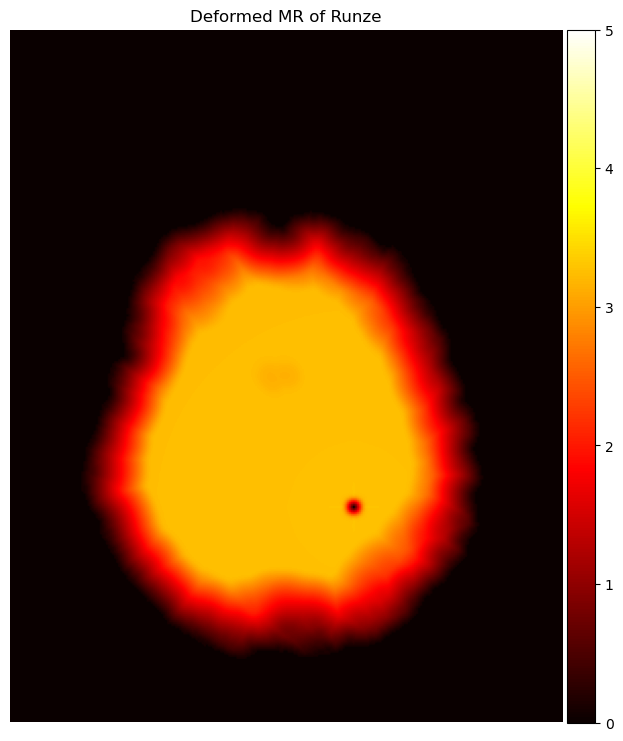

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
dist_ = (0.7*flow[0,0,:,:,:])**2+(0.7*flow[0,1,:,:,:])**2+flow[0,2,:,:,:]**2
dist_ = dist_**0.5
fig, ax = plt.subplots(1,1,figsize=(12,9))
np.vectorize(lambda ax: ax.axis('off'))(ax)

imx3 = ax.imshow(dist_[:,:,98].T, cmap='hot', vmin=0,vmax = 5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imx3, cax=cax, orientation='vertical')
ax.set_title('Deformed MR of Runze')

Visualization of the MR, CT and CBCT

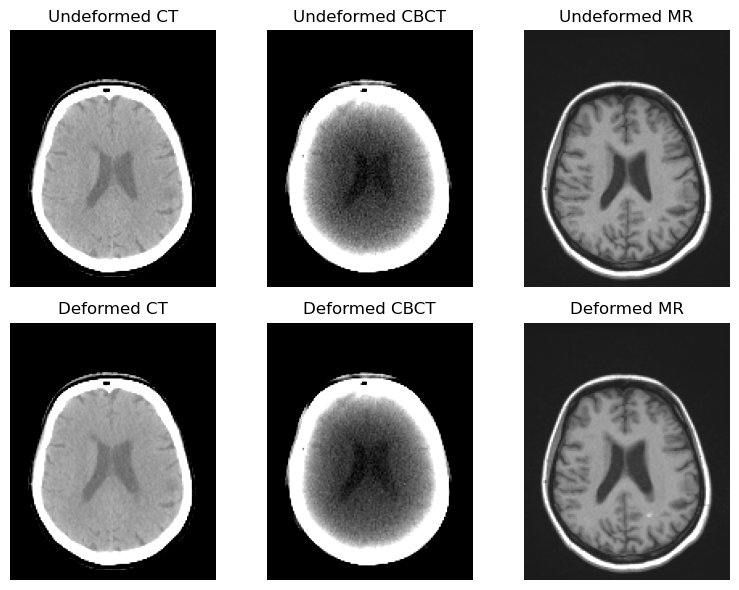

In [59]:
import matplotlib.pyplot as plt
islice = 72
fig, ax = plt.subplots(2,3,figsize=(8,6))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(ct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 0].set_title('Undeformed CT')
ax[1, 0].imshow(ct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 0].set_title('Deformed CT')
ax[0, 1].imshow(cbct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 1].set_title('Undeformed CBCT')
ax[1, 1].imshow(cbct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 1].set_title('Deformed CBCT')
ax[0, 2].imshow(mr[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Undeformed MR')
ax[1, 2].imshow(mr_deform[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[1, 2].set_title('Deformed MR')
plt.tight_layout()
plt.show()

### Step 5-6: See Runze's warping in his dataset

fixed_img
moving_img
fixed_warp
moving_truth
ventricle_fixed
ventricle_moving
affine
flow
sources
cbct
cbct_warp
structure_fixed
structure_moving


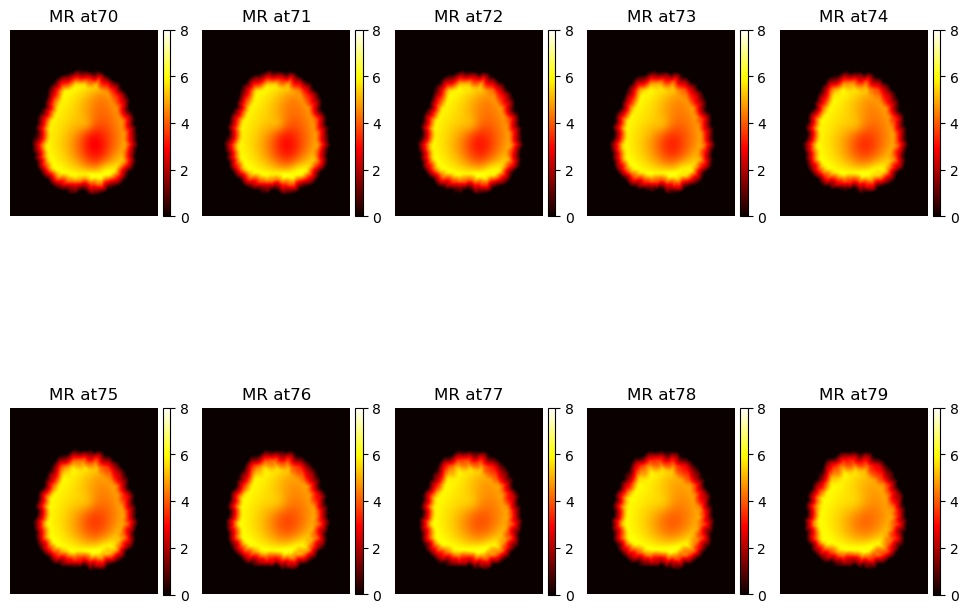

In [90]:
train_path4 = "/mnt/blackhole-data2/RadOnc_Brain/NonRigid_Training_CBCT"
name = '/0.npz'
path = np.load(train_path4+name,allow_pickle= True)
img = path['moving_img']
img_ori = path['moving_truth']
data = path['flow']
mask = path['ventricle_fixed']
for key in path.keys():
    print(key)

ventricle_mask=(mask== 23) + (mask == 24)
islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))
dist = ((0.7*data[0,:,:,:,0])**2+(0.7*data[0,:,:,:,1])**2+data[0,:,:,:,2]**2)**0.5

fig, ax = plt.subplots(2,5,figsize=(12,9))
np.vectorize(lambda ax: ax.axis('off'))(ax)
for i in range(10):
    if i <5:
        row = 0
    else:
        row = 1
    im = ax[row,np.mod(i,5)].imshow(dist[:,:,113-5+i].T, cmap='hot', vmin=0,vmax = 8)
    divider = make_axes_locatable(ax[row,np.mod(i,5)])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[row,np.mod(i,5)].set_title('MR at'+ str(islice-5+i))

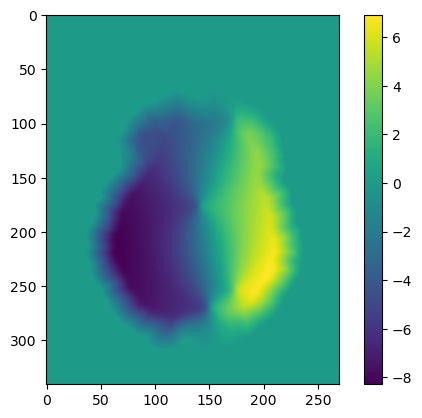

In [64]:
from layers import VecInt
# diff = VecInt(inshape=data.shape],nsteps = 7)(data)
plt.imshow(data[0,:,:,96,0].T)
plt.colorbar()

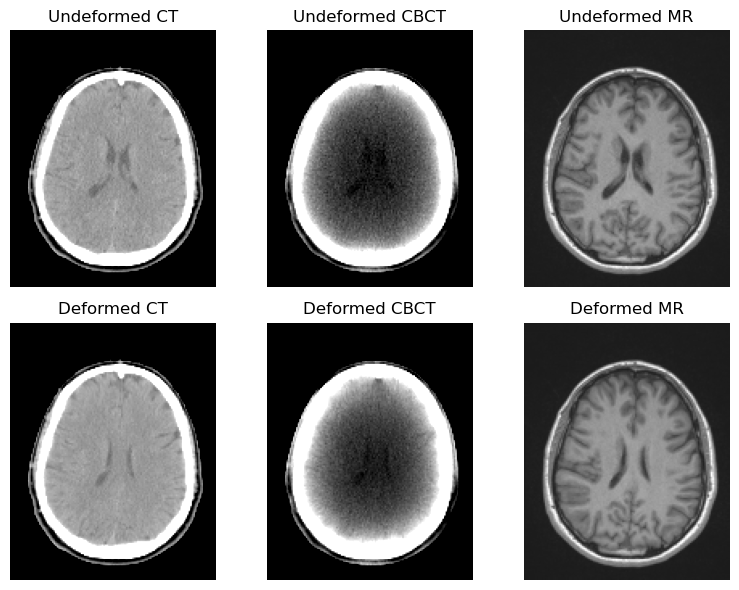

In [66]:
mr_deform= path['moving_img']
mr= path['moving_truth']
ct= path['fixed_img']
ct_deform= path['fixed_warp']
cbct = path['cbct']
cbct_deform = path['cbct_warp']

fig, ax = plt.subplots(2,3,figsize=(8,6))
np.vectorize(lambda ax: ax.axis('off'))(ax)
ax[0, 0].imshow(ct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 0].set_title('Undeformed CT')
ax[1, 0].imshow(ct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 0].set_title('Deformed CT')
ax[0, 1].imshow(cbct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[0, 1].set_title('Undeformed CBCT')
ax[1, 1].imshow(cbct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
ax[1, 1].set_title('Deformed CBCT')
ax[0, 2].imshow(mr[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[0, 2].set_title('Undeformed MR')
ax[1, 2].imshow(mr_deform[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
ax[1, 2].set_title('Deformed MR')
plt.tight_layout()
plt.show()

In [67]:
def plot_flow(flow, z, spacing=4, ax=None):
    def plot_grid(x,y, ax=ax, **kwargs):
        ax = ax or plt.gca()
        segs1 = np.stack((x,y), axis=2)
        segs2 = segs1.transpose(1,0,2)
        ax.add_collection(LineCollection(segs1, **kwargs))
        ax.add_collection(LineCollection(segs2, **kwargs))
        ax.autoscale()

    grid_x,grid_y = np.meshgrid(np.linspace(0, flow.shape[1], flow.shape[1]), np.linspace(0, flow.shape[0], flow.shape[0]))
#     plot_grid(grid_x[::spacing, ::spacing],grid_y[::spacing, ::spacing], ax=ax,  color="lightgrey")

    distx = grid_x[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 1]
    disty = grid_y[::spacing, ::spacing] - flow[::spacing, ::spacing, z, 0]
    # distx, disty = f(grid_x,grid_y)
    plot_grid(disty, distx, ax=ax, color="black", linewidths=1)

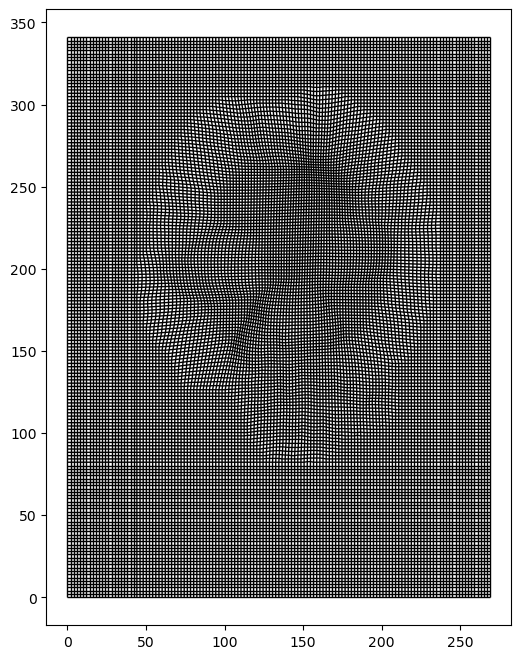

In [74]:
plt.style.use('default')
from matplotlib.collections import LineCollection
fig, ax = plt.subplots(figsize=(6,8))
plot_flow(data[0], spacing=2, z=islice, ax=ax)

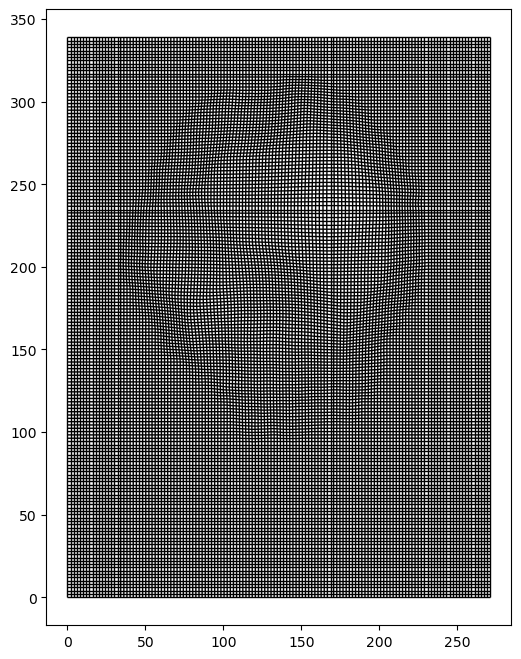

In [80]:
plt.style.use('default')
from matplotlib.collections import LineCollection
fig, ax = plt.subplots(figsize=(6,8))
plot_flow(flow[0].permute(1,2,3,0).numpy(), spacing=2, z=islice, ax=ax)